In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("ggplot")
from ipywidgets import interact
import numpy as np
import matplotlib as mpl
import arrow

%matplotlib inline

In [10]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################

# Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)

idx_weight = "Weight (kg)"
# make dateColumn a datetime.
idx_date = "Start"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])
# Create Time Period Groups
idx_month_year = "month_year"
df[idx_month_year] = df[idx_date].apply(lambda t: f"{t.month}-{t.year-2000}")

idx_week_year = "week_year"
df[idx_week_year] = df[idx_date].apply(lambda t: f"{t.week}-{t.year-2000}")

# Data cleaning
###########################

# Remove 0 weight values.
df = df.replace(0, np.nan)
# Throw away junk data at the start of time


df = df["2010/1/1":]  # type: ignore
# (not sure why mypy can't handle this)
# KG to lbs
df[idx_weight] = df[idx_weight] * 2.2


# Helpful time aliases
df_alltime = df

In [5]:
def plot_weight_over_time(df, x):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width.
    height_in_inches = 8
    mpl.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

    ax = sns.boxplot(x=x, y=idx_weight, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # ax.set_title("Weight")
    ax.set_xlabel("date")
    ax.set_ylabel("lbs")

# Recent Weight By Weeks

/home/idvorkin/.local/share/virtualenvs/jupyter-mS77vUq-/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


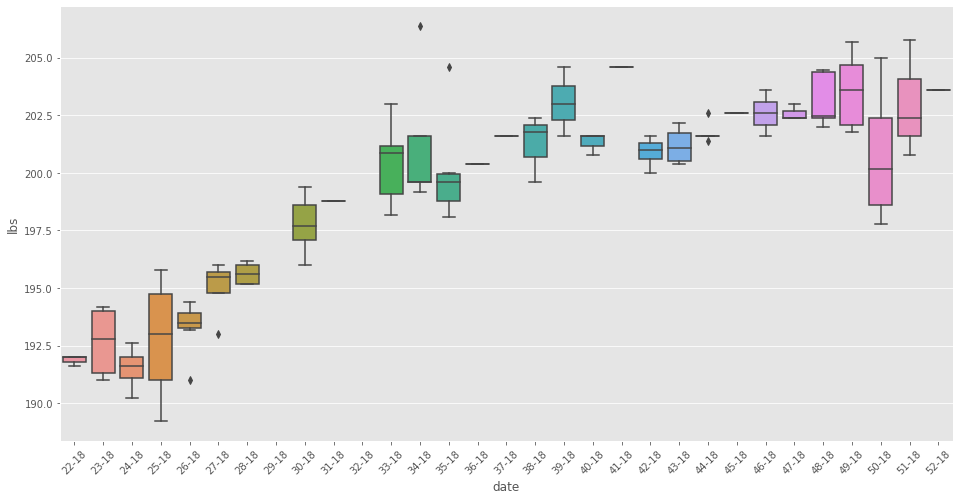

In [6]:
earliest = arrow.utcnow().shift(months=-12).date()
df_recent = df[df[idx_date] > earliest]
plot_weight_over_time(df_recent, idx_week_year)

# Historical Weight By Month

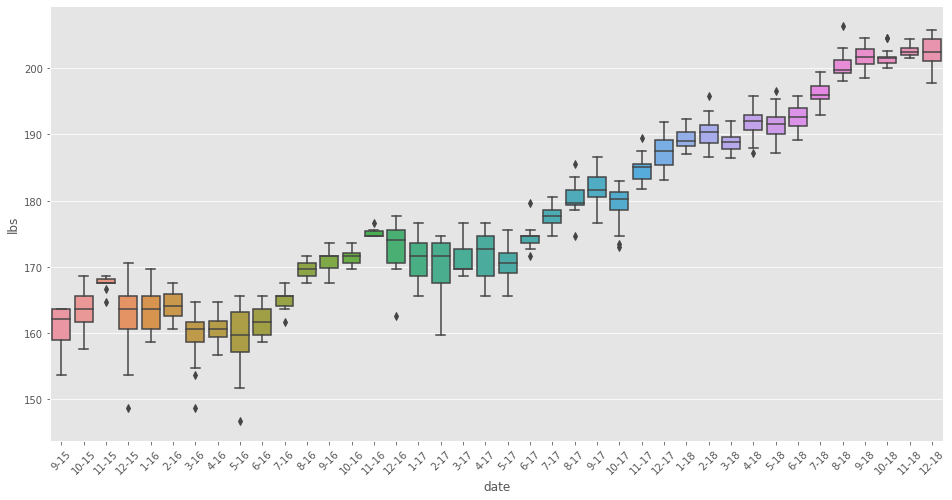

In [7]:
plot_weight_over_time(df_alltime, idx_month_year)

# Time Series Analysis Methodology using resampling

In [8]:
tempFrame = df.resample("W").apply([len, np.min, np.median, np.max])
tempFrame.sort_index(ascending=False).head(15)
# Can graph interactively using Bokeh @
# https://stackoverflow.com/questions/45972782/plot-time-series-graph-using-bokeh

Weight (kg)                                    
                   len        amin      median        amax
Start                                                     
2018-12-30         2.0  203.572256  203.572256  203.572256
2018-12-23         7.0  200.778127  202.374772  205.767643
2018-12-16         7.0  197.784417  200.179385  204.969320
2018-12-09         7.0  201.776030  203.572256  205.667852
2018-12-02         7.0  201.975611  202.474562  204.470369
2018-11-25         7.0  202.374772  202.374772  202.973514
2018-11-18         7.0  201.576449  202.574352  203.572256
2018-11-11         7.0  202.574352  202.574352  202.574352
2018-11-04         7.0  201.376869  201.576449  202.574352
2018-10-28         7.0  200.378965  201.077498  202.175191
2018-10-21         7.0  199.979804  200.977707  201.576449
2018-10-14         7.0  204.570159  204.570159  204.570159
2018-10-07         7.0  200.778127  201.576449  201.576449
2018-09-30         7.0  201.576449  202.973514  204.570159
2018-09-23         7.0  199.580643  201.776030  202.374772